In [ ]:
import gdown
gdown.download("https://drive.google.com/file/d/1YUbTBFrk9QF0ivR5F640G3dhCMC3XQUZ/view?usp=sharing", "dataset.zip", quiet=False, fuzzy=True)
gdown.extractall("dataset.zip")

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

In [ ]:
torch.manual_seed(9815)

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create a data transformation pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchsummary import summary
model = Net()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 512]       4,194,816
           Linear-11                   [-1, 10]           5,130
Total params: 4,293,642
Trainable params: 4,293,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forw

In [ ]:
dataset = torchvision.datasets.ImageFolder('dataset', transform=transform)
N = len(dataset)
print(f'The number of classes in the dataset = {len(dataset.class_to_idx)}')

N_train = int(0.8 * N)
N_validation = int(0.1 * N)
N_test = N - (N_train + N_validation)
train, validation, test = torch.utils.data.random_split(dataset, (N_train, N_validation, N_test))

print(f'The length of the dataset = {N} instances')
print(f'The length of the training set = {len(train)} instances')
print(f'The length of the validation set = {len(validation)} instances')
print(f'The length of the test set = {len(test)} instances')

batch_size = 64
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

The number of classes in the dataset = 2
The length of the dataset = 922 instances
The length of the training set = 737 instances
The length of the validation set = 92 instances
The length of the test set = 93 instances


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Availabe device for training is: {device}')

Availabe device for training is: cuda


In [ ]:
# Training parameters
epochs = 50
learning_rate = 0.001

# NN definition
model = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_acc = []
train_loss = []
valid_acc = []
valid_loss = []


# Train the model
for epoch in range(epochs):
    print('-' * 80)
    print(f'Epoch {epoch + 1}/{epochs}')

    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
            dataloader = trainloader
            dataset_size = N_train
        else:
            model.eval()
            dataloader = validationloader
            dataset_size = N_validation

        running_loss = 0.0
        running_corrects = 0
        for data in dataloader:
            # Get the training data items of the current batch
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
              # Forward pass
              outputs = model(inputs)
              # Predict the current batch
              _, preds = torch.max(outputs, 1)
              # Compute loss
              loss = criterion(outputs, labels)

              if phase == 'train':
                # Set the gradients of all the parameters of the model to zero
                optimizer.zero_grad()
                # Backward propagation to calculate the gradient
                loss.backward()
                # Update the NN weights by using the gradient
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)


        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        if phase == 'valid':
          valid_acc.append(epoch_acc)
          valid_loss.append(epoch_loss)
        else:
          train_acc.append(epoch_acc)
          train_loss.append(epoch_loss)

        print('{} loss: {:.4f} --------------- {} accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

        # deep copy the model
        if phase == 'valid' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())


time_elapsed = time.time() - since
print('-' * 80)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation accuracy: {:4f}'.format(best_acc))

# load best model weights
print('Loading final model weights...')
model.load_state_dict(best_model_wts)

--------------------------------------------------------------------------------
Epoch 1/50
train loss: 1.1709 --------------- train accuracy: 0.5305
valid loss: 1.0166 --------------- valid accuracy: 0.6413
--------------------------------------------------------------------------------
Epoch 2/50
train loss: 0.5334 --------------- train accuracy: 0.7408
valid loss: 0.6073 --------------- valid accuracy: 0.6522
--------------------------------------------------------------------------------
Epoch 3/50
train loss: 0.4690 --------------- train accuracy: 0.7748
valid loss: 0.6308 --------------- valid accuracy: 0.6196
--------------------------------------------------------------------------------
Epoch 4/50
train loss: 0.4142 --------------- train accuracy: 0.8019
valid loss: 0.5123 --------------- valid accuracy: 0.7391
--------------------------------------------------------------------------------
Epoch 5/50
train loss: 0.4237 --------------- train accuracy: 0.8073
valid loss: 0.5059

<All keys matched successfully>

In [ ]:
if device.type == "cuda":
  train_acc = [train_acc[i].item() for i in range(len(train_acc))]
  valid_acc = [valid_acc[i].item() for i in range(len(valid_acc))]

In [ ]:
from scipy.signal import savgol_filter
train_loss_s = savgol_filter(train_loss, window_length=21, polyorder=3, mode="nearest")
valid_loss_s = savgol_filter(train_loss, window_length=5, polyorder=3, mode="nearest")
train_acc_s = savgol_filter(train_acc, window_length=21, polyorder=3, mode="nearest")
valid_acc_s = savgol_filter(valid_acc, window_length=21, polyorder=3, mode="nearest")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Return the value and the index of the maximum number of the output vector
            _, predicted = torch.max(outputs, 1)

            # Save the predicted values from the model of the current batch
            predicted = predicted.data.cpu().numpy()
            y_pred.extend(predicted)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)
            
    return np.asarray(y_pred), np.asarray(y_true)

# Test the model on the test dataset
y_pred, y_true = predict(model, testloader, device)
        
classification_report = classification_report(y_true, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        54
           1       0.90      0.92      0.91        39

    accuracy                           0.92        93
   macro avg       0.92      0.92      0.92        93
weighted avg       0.93      0.92      0.92        93



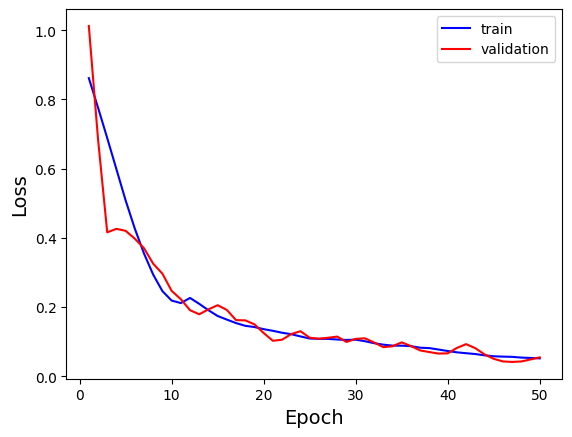

In [ ]:
from matplotlib import pyplot as plt

values = [i for i in range(1, epochs + 1)]
plt.style.use('default')
plt.plot(values, train_loss_s, color='b', label='train')
plt.plot(values, valid_loss_s, color='r', label='validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()

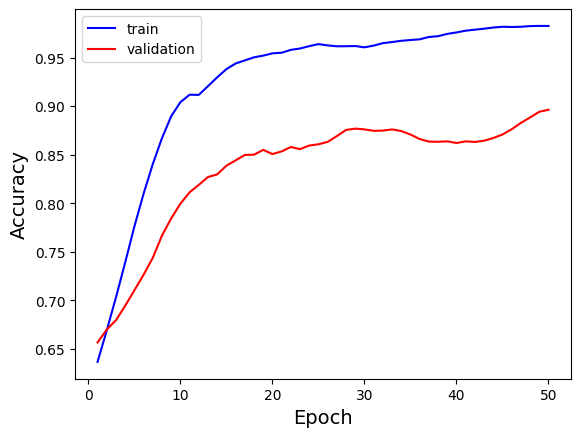

In [ ]:
plt.style.use('default')
plt.plot(values, train_acc_s, color='b', label='train')
plt.plot(values, valid_acc_s, color='r', label='validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
import shutil
torch.save(model, './cnn.pth')
drive.mount('/content/drive')
shutil.copy('./cnn.pth', '/content/drive/MyDrive/Satellite Imaging/SI Project/models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Satellite Imaging/SI Project/models/cnn.pth'